In [ ]:
import tf_silent
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec

from network import Network
from optimizer import L_BFGS_B
from streamfunction_pinn import StreamFunctionPINN



# imitate flow behavior at pipe inlet, zero at edges & max around center
def u_0(xy):
    """
    Initial wave form.
    Args:
        tx: variables (t, x) as tf.Tensor.
    Returns:
        u(t, x) as tf.Tensor.
    """

    x = xy[..., 0, None]
    y = xy[..., 1, None]


    return    4*y*(1 - y) 



def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """
    from matplotlib.patches import Circle
    vmin = np.min(z)
    vmax = np.max(z)
    font1 = {'family':'serif','size':20}
    fig, ax = plt.subplots(figsize=(10, 8))
    cs1 = ax.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    cs2 = ax.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    circle = Circle((0.5, 0.5), 0.1, fc='black', zorder=10)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_title(title, fontdict=font1)
    ax.set_xlabel("x", fontdict=font1)
    ax.set_ylabel("y", fontdict=font1)
    ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(cs2, ax=ax, pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()
    plt.show()


# if __name__ == '__main__':
#     """
#     Test the physics informed neural network (PINN) model
#     for the cavity flow governed by the steady Navier-Stokes equation.
#     """

# number of training samples
num_train_samples = 5000
num_cylinder_samples = 4000  # more points around cylinder
num_wake_samples = 4000      # more points in wake region
num_annulus_samples = 3000   # more points in annulus
num_test_samples = 200

# inlet flow velocity
u0 = 1
rho = 1
mu = 0.025
nu = mu / rho

# build a core network model for streamfunction (output: 1)
network = Network().build(num_inputs=2, layers=[48,48,48,48], activation='tanh', num_outputs=1)
network.summary()
# build a StreamFunctionPINN model
pinn = StreamFunctionPINN(network, rho=1, nu=0.025)


# Domain and circle data
x_f = 2
x_ini = 0
y_f = 1
y_ini = 0
Cx = 0.5
Cy = 0.5
a = 0.1
b = 0.1

# Cylinder boundary points (more points)
theta_cyl = np.linspace(0, 2*np.pi, num_cylinder_samples, endpoint=False)
xyt_circle = np.stack([Cx + a * np.cos(theta_cyl), Cy + b * np.sin(theta_cyl)], axis=-1)

# Interior domain sampling (excluding cylinder)
xyt_eqn = np.random.rand(num_train_samples, 2)
xyt_eqn[...,0] = (x_f - x_ini)*xyt_eqn[...,0] + x_ini
xyt_eqn[...,1] = (y_f - y_ini)*xyt_eqn[...,1] + y_ini
# Remove points inside the cylinder
mask = ((xyt_eqn[:, 0] - Cx)**2/a**2 + (xyt_eqn[:, 1] - Cy)**2/b**2) >= 1
xyt_eqn = xyt_eqn[mask]

# Annulus region (more points)
theta = np.random.uniform(0, 2*np.pi, num_annulus_samples)
r = np.sqrt(np.random.uniform(1, 6.25, num_annulus_samples))
x = Cx + a * r * np.cos(theta)
y = Cy + b * r * np.sin(theta)
xyt_annulus = np.stack([x, y], axis=1)

# Wake region (more points)
x_strip = np.random.uniform(0.55, 0.75, num_wake_samples)
y_strip = np.random.uniform(0.3, 0.7, num_wake_samples)
xyt_strip = np.stack([x_strip, y_strip], axis=1)
# Remove points inside the cylinder in the wake
mask_wake = ((xyt_strip[:, 0] - Cx)**2/a**2 + (xyt_strip[:, 1] - Cy)**2/b**2) >= 1
xyt_strip = xyt_strip[mask_wake]

# Combine all interior points
xyt_interior = np.concatenate([xyt_eqn, xyt_annulus, xyt_strip], axis=0)

# Boundary points
xyt_w1 = np.random.rand(num_train_samples, 2)
xyt_w1[..., 0] = (x_f - x_ini)*xyt_w1[...,0] + x_ini
xyt_w1[..., 1] = y_ini

xyt_w2 = np.random.rand(num_train_samples, 2)
xyt_w2[..., 0] = (x_f - x_ini)*xyt_w2[...,0] + x_ini
xyt_w2[..., 1] = y_f

xyt_out = np.random.rand(num_train_samples, 2)
xyt_out[..., 0] = x_f

xyt_in = np.random.rand(num_train_samples, 2)
xyt_in[..., 0] = x_ini

# Wall boundary (combine top and bottom)
xyt_wall = np.concatenate([xyt_w1, xyt_w2], axis=0)

# Inlet boundary
xyt_inlet = xyt_in

# Target values for boundary conditions
# For streamfunction, set psi=0 on cylinder and walls, and set inlet/outlet as needed
psi_wall = np.zeros((xyt_wall.shape[0], 1))
psi_cylinder = np.zeros((xyt_circle.shape[0], 1))
psi_inlet = np.zeros((xyt_inlet.shape[0], 1))  # adjust if needed

# For velocity BCs (for penalty), set u_target, v_target as needed
u_wall = np.zeros((xyt_wall.shape[0], 1))
v_wall = np.zeros((xyt_wall.shape[0], 1))
# For cylinder, no-slip
u_cylinder = np.zeros((xyt_circle.shape[0], 1))
v_cylinder = np.zeros((xyt_circle.shape[0], 1))
# For inlet, parabolic profile
u_inlet = u_0(xyt_inlet)
v_inlet = np.zeros((xyt_inlet.shape[0], 1))

# Normals and tangents for wall/cylinder (for no-penetration and no-slip)
# Example: for bottom wall, normal is (0,1), tangent is (1,0)
wall_normal = (np.zeros((xyt_wall.shape[0], 1)), np.ones((xyt_wall.shape[0], 1)))
wall_tangent = (np.ones((xyt_wall.shape[0], 1)), np.zeros((xyt_wall.shape[0], 1)))
# For cylinder, normal is radial
dx = xyt_circle[:, 0:1] - Cx
dy = xyt_circle[:, 1:2] - Cy
norm = np.sqrt(dx**2 + dy**2)
cyl_normal = (dx/norm, dy/norm)
# Tangent is perpendicular
cyl_tangent = (-dy/norm, dx/norm)


# Define the total loss with penalty method (keep in main file for flexibility)
def total_loss():
    λ_bc = 1.0
    λ_eqm = 1e6
    λ_pmpg = 1.0

    # PMPG loss (pressure gradient surrogate)
    loss_pmpg = tf.reduce_mean(pinn.pmpg_residual(tf.constant(xyt_interior, dtype=tf.float32)))
    # Equilibrium (vorticity transport) loss
    loss_eqm = tf.reduce_mean(tf.square(pinn.equilibrium_residual(tf.constant(xyt_interior, dtype=tf.float32))))
    # Wall boundary loss (no-slip and no-penetration)
    loss_wall = pinn.boundary_residual(tf.constant(xyt_wall, dtype=tf.float32),
                                        tf.constant(u_wall, dtype=tf.float32),
                                        tf.constant(v_wall, dtype=tf.float32),
                                        normal=wall_normal, tangent=wall_tangent,
                                        enforce_normal=True, enforce_tangent=True)
    # Cylinder boundary loss (no-slip and no-penetration)
    loss_cylinder = pinn.boundary_residual(tf.constant(xyt_circle, dtype=tf.float32),
                                            tf.constant(u_cylinder, dtype=tf.float32),
                                            tf.constant(v_cylinder, dtype=tf.float32),
                                            normal=cyl_normal, tangent=cyl_tangent,
                                            enforce_normal=True, enforce_tangent=True)
    # Inlet boundary loss (prescribed u, v)
    loss_inlet = pinn.boundary_residual(tf.constant(xyt_inlet, dtype=tf.float32),
                                        tf.constant(u_inlet, dtype=tf.float32),
                                        tf.constant(v_inlet, dtype=tf.float32),
                                        normal=None, tangent=None,
                                        enforce_normal=False, enforce_tangent=False)
    loss_bc = loss_wall + loss_cylinder + loss_inlet
    return λ_bc * loss_bc + λ_eqm * loss_eqm + λ_pmpg * loss_pmpg


# Train the model using L-BFGS-B algorithm
# lbfgs = L_BFGS_B(model=network, loss_fn=total_loss)
# lbfgs.fit()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 48)                144       
                                                                 
 dense_1 (Dense)             (None, 48)                2352      
                                                                 
 dense_2 (Dense)             (None, 48)                2352      
                                                                 
 dense_3 (Dense)             (None, 48)                2352      
                                                                 
 dense_4 (Dense)             (None, 1)                 49        
                                                                 
Total params: 7249 (28.32 KB)
Trainable params: 7249 (28.32 K

L-BFGS-B:  12%|█▏        | 3501/30000 [05:21<40:30, 10.90iter/s, loss=0.149]  


In [4]:
def contour(x, y, z, title, levels=100):
    """
    Contour plot.
    Args:
        grid: plot position.
        x: x-array.
        y: y-array.
        z: z-array.
        title: title string.
        levels: number of contour lines.
    """
    from matplotlib.patches import Circle
    vmin = np.min(z)
    vmax = np.max(z)
    font1 = {'family':'serif','size':20}
    fig, ax = plt.subplots(figsize=(10, 8))
    cs1 = ax.contour(x, y, z, colors='k', linewidths=0.2, levels=levels)
    cs2 = ax.contourf(x, y, z, cmap='rainbow', levels=levels, norm=Normalize(vmin=vmin, vmax=vmax))
    circle = Circle((0.5, 0.5), 0.1, fc='black', zorder=10)
    ax.add_patch(circle)
    ax.set_aspect('equal')
    ax.set_title(title, fontdict=font1)
    ax.set_xlabel("x", fontdict=font1)
    ax.set_ylabel("y", fontdict=font1)
    ax.tick_params(axis='both', which='major', labelsize=15)
    cbar = fig.colorbar(cs2, ax=ax, pad=0.03, aspect=25, format='%.0e')
    cbar.mappable.set_clim(vmin, vmax)
    cbar.ax.tick_params(labelsize=15)
    plt.tight_layout()
    plt.show()

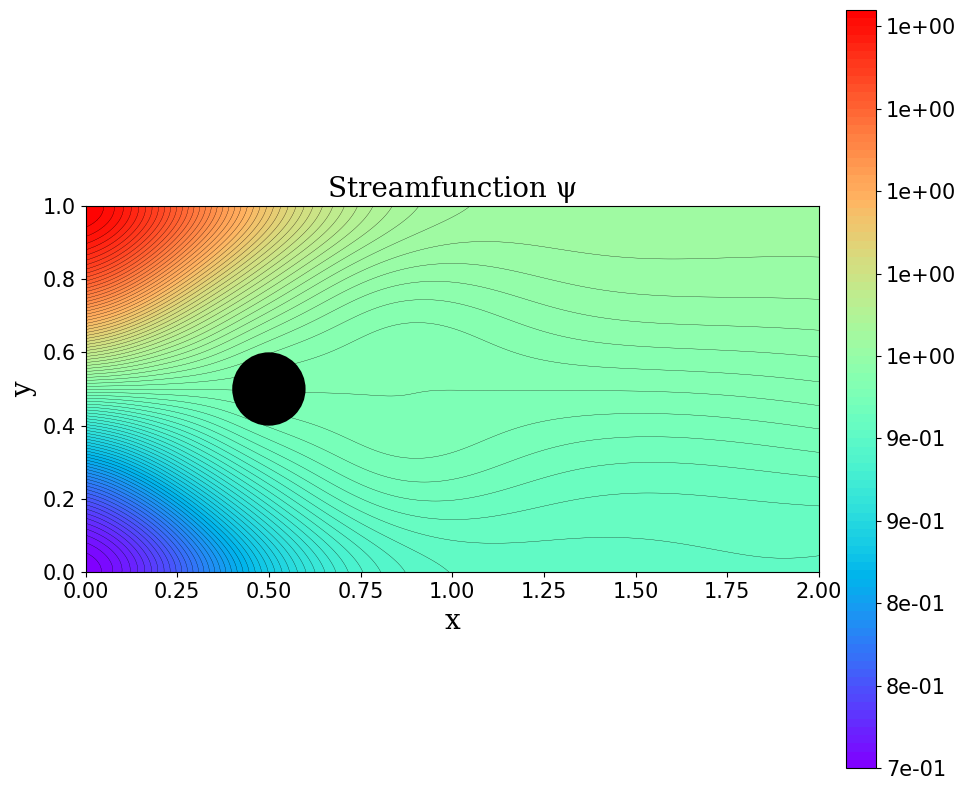

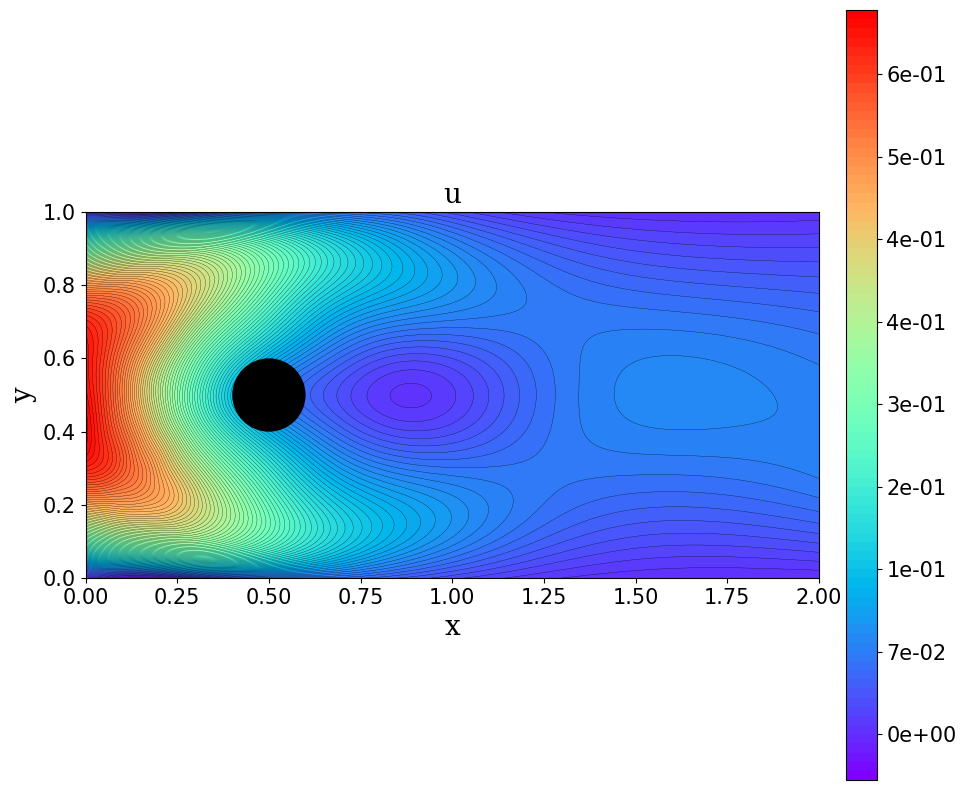

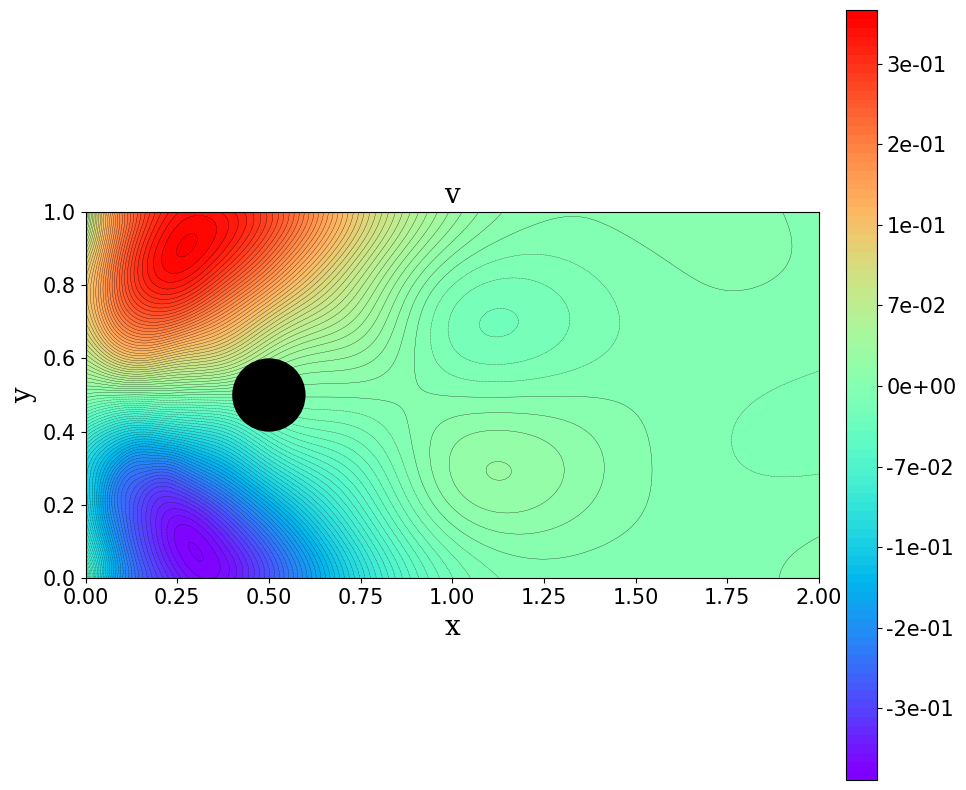

In [5]:

    # Prediction and plotting
    x = np.linspace(x_ini, x_f, num_test_samples)
    y = np.linspace(y_ini, y_f, num_test_samples)
    x, y = np.meshgrid(x, y)
    xy = np.stack([x.flatten(), y.flatten()], axis=-1)
    u, v = pinn.predict_uv(tf.constant(xy, dtype=tf.float32))
    u = u.numpy().reshape(x.shape)
    v = v.numpy().reshape(x.shape)
    # Optionally, plot psi as well
    psi = network(xy).numpy().reshape(x.shape)

    # # Plotting (no pressure, only u, v, psi)
    contour(x, y, psi, 'Streamfunction ψ')
    contour(x, y, u, 'u')
    contour(x, y, v, 'v')

    # fig = plt.figure(figsize=(16, 8))
    # contour(x, y, u, 'u')
    # plt.tight_layout()
    # plt.show()

    # fig = plt.figure(figsize=(16, 8))
    # contour(x, y, v, 'v')
    # plt.tight_layout()
    # plt.show()
    

    # ###########################
    # from matplotlib.patches import Circle
    # font1 = {'family':'serif','size':20}

    # fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
    # cf0 = ax0.contourf(x, y, p, np.arange(-0.2, 1, .02),
    #                extend='both',cmap='rainbow')
    # cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    # plt.title("p", fontdict = font1)
    # plt.xlabel("x", fontdict = font1)
    # plt.ylabel("y", fontdict = font1)
    # ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    # plt.tick_params(axis='both', which='major', labelsize=15)
    # cbar0.ax.tick_params(labelsize=15)
    # plt.show()

    # ###########################

    # fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
    # cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
    #                extend='both',cmap='rainbow')
    # cbar0 = plt.colorbar(cf0, )
    # plt.title("u", fontdict = font1)
    # plt.xlabel("x", fontdict = font1)
    # plt.ylabel("y", fontdict = font1)
    # ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    # plt.tick_params(axis='both', which='major', labelsize=15)
    # cbar0.ax.tick_params(labelsize=15)
    # plt.show()

    # ###########################

    # fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
    # cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
    #                extend='both',cmap='rainbow')
    # cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
    # plt.title("v", fontdict = font1)
    # plt.xlabel("x", fontdict = font1)
    # plt.ylabel("y", fontdict = font1)
    # ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
    # plt.tick_params(axis='both', which='major', labelsize=15)
    # cbar0.ax.tick_params(labelsize=15)
    # plt.show()


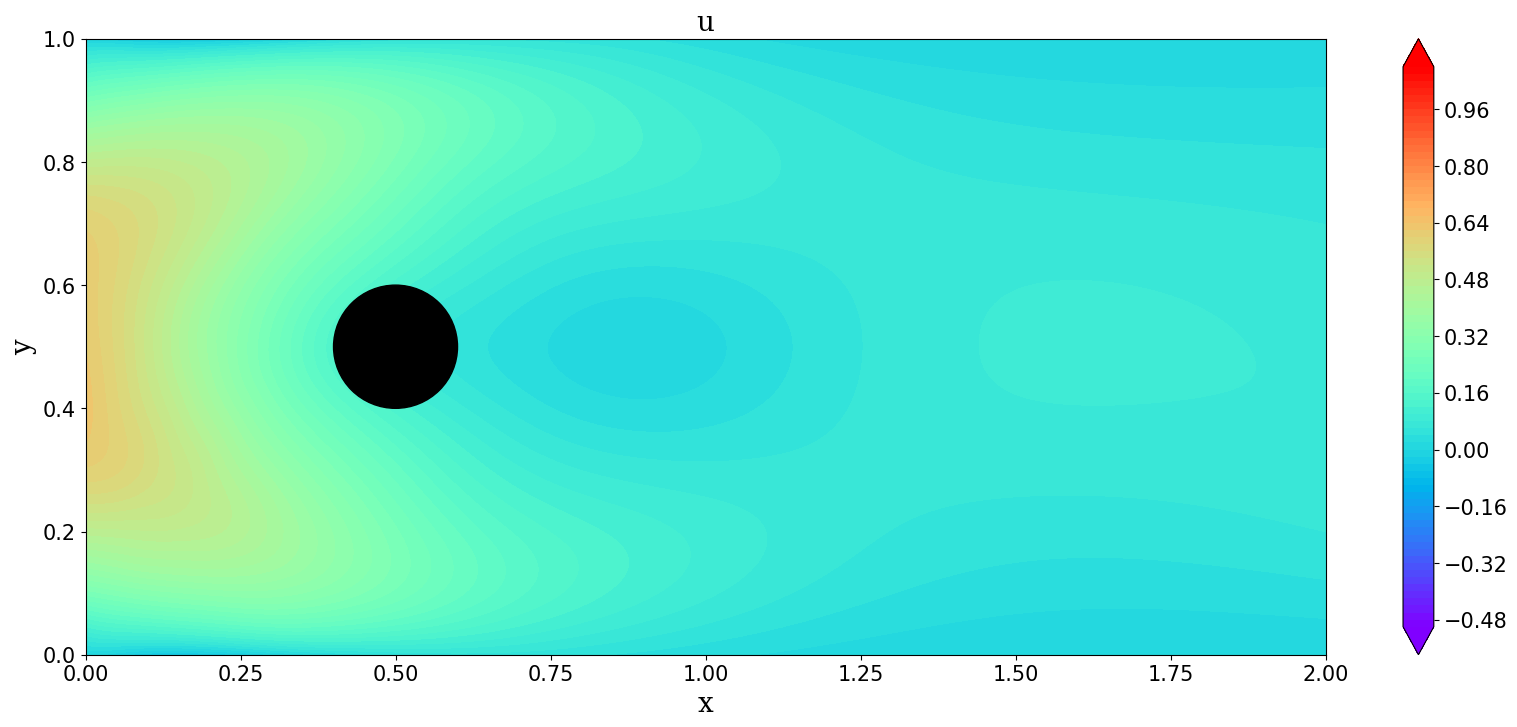

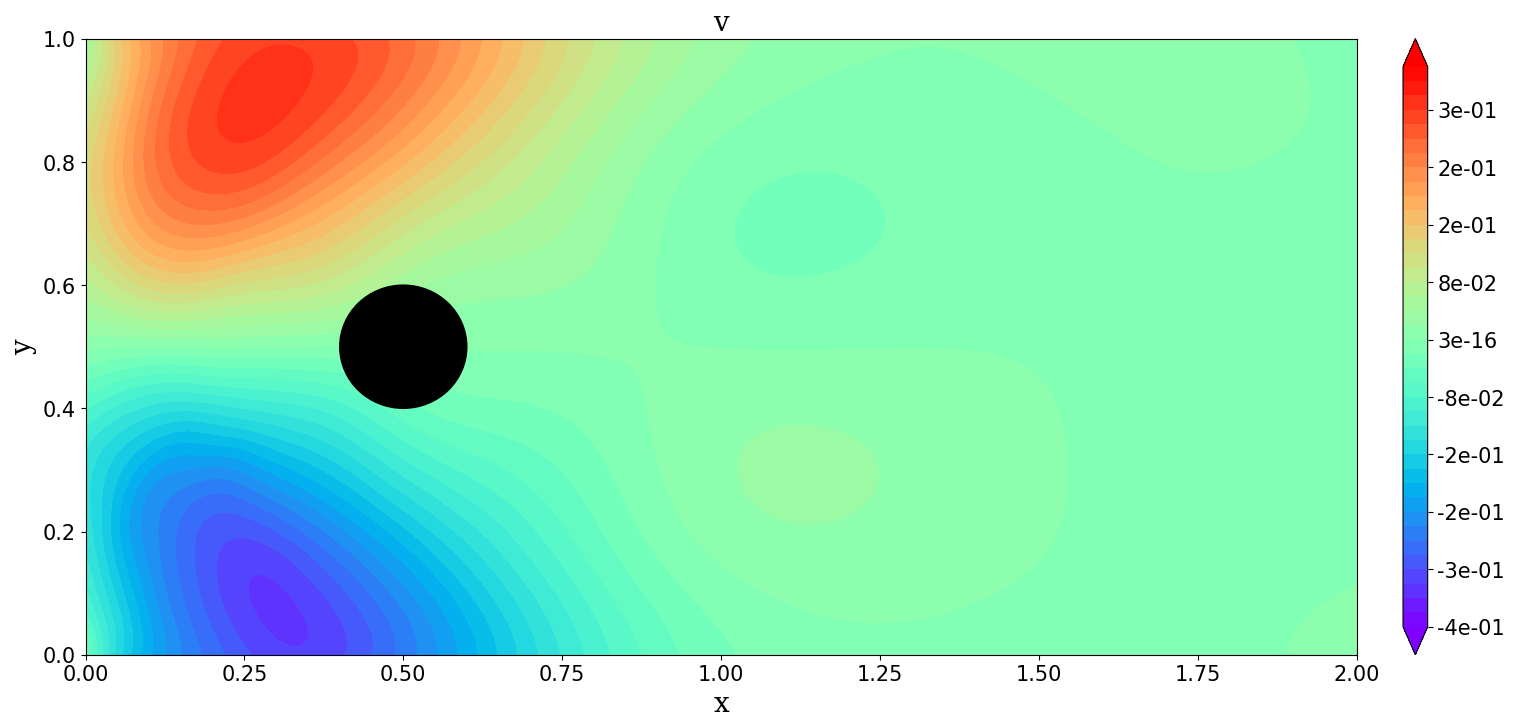

In [6]:
fig0, ax0 = plt.subplots(1, 1, figsize=(20,8))
cf0 = ax0.contourf(x, y, u, np.arange(-0.5, 1.1, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, )
plt.title("u", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

###########################

fig0, ax0 = plt.subplots(1, 1,figsize=(20,8))
cf0 = ax0.contourf(x, y, v, np.arange(-0.4, 0.4, .02),
                extend='both',cmap='rainbow')
cbar0 = plt.colorbar(cf0, pad=0.03, aspect=25, format='%.0e')
plt.title("v", fontdict = font1)
plt.xlabel("x", fontdict = font1)
plt.ylabel("y", fontdict = font1)
ax0.add_patch(Circle((0.5, 0.5), 0.1,color="black"))
plt.tick_params(axis='both', which='major', labelsize=15)
cbar0.ax.tick_params(labelsize=15)
plt.show()

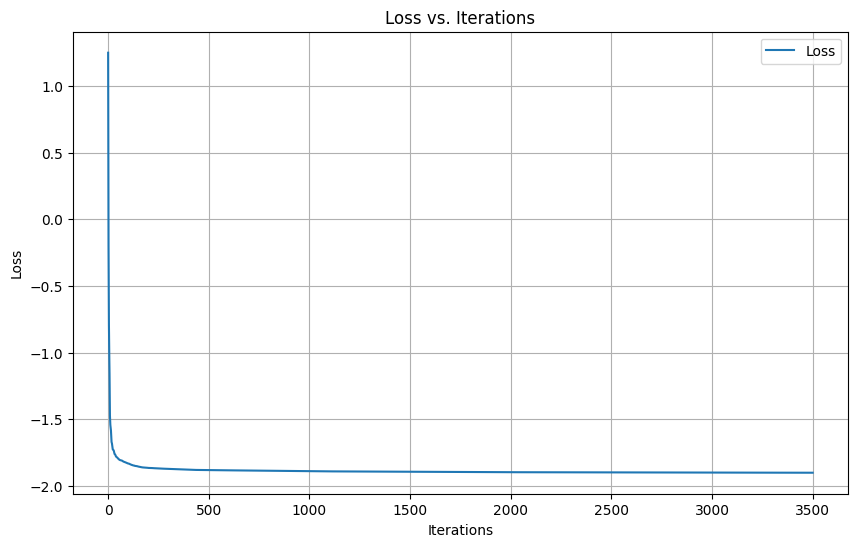

In [7]:
# Plot the loss curve
plt.figure(figsize=(10, 6))
plt.plot(range(len(lbfgs.loss_history)), np.log(lbfgs.loss_history), label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss vs. Iterations')
plt.legend()
plt.grid()
plt.savefig('loss_curve_Re40.png')
plt.show()

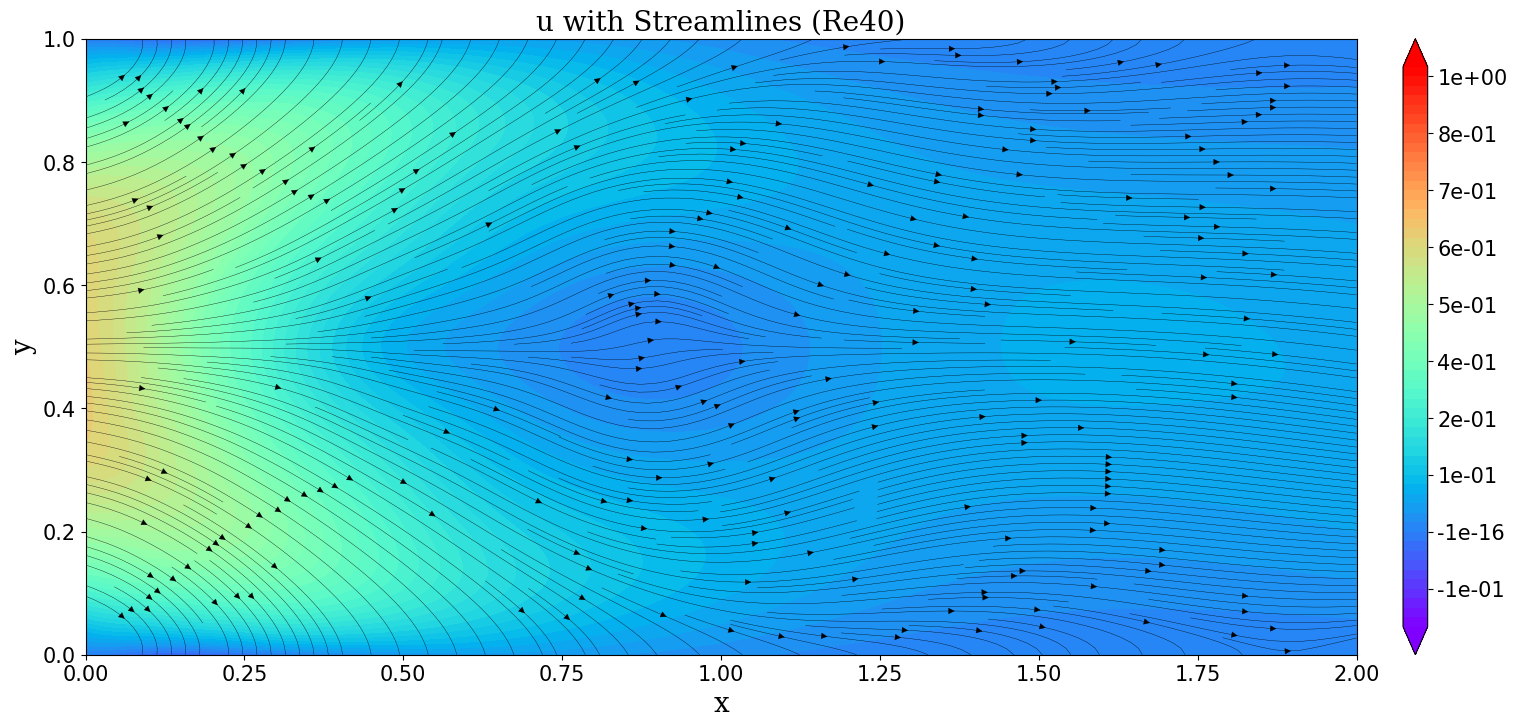

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

font1 = {'family':'serif','size':20}

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
# Contourf for pressure (or any scalar field)
cf = ax.contourf(x, y, u, np.arange(-0.2, 1, .02), extend='both', cmap='rainbow')
cbar = plt.colorbar(cf, pad=0.03, aspect=25, format='%.0e')
# Streamlines for velocity field
strm = ax.streamplot(x, y, u, v, color='k', density=3, linewidth=0.25)
# Add cylinder
# ax.add_patch(Circle((0.5, 0.5), 0.1, color="black"))
plt.title("u with Streamlines (Re40)", fontdict=font1)
plt.xlabel("x", fontdict=font1)
plt.ylabel("y", fontdict=font1)
plt.tick_params(axis='both', which='major', labelsize=15)
cbar.ax.tick_params(labelsize=15)
plt.savefig('u_streamlines_Re40.png', dpi=300)
plt.show()